Results are posted in the report.
Only plots are shown here .

To get better results, run this code with epoch set to 40-50 , it will take a while . It also requires good GPU . i ran it at 10 epochs which took alot of time , results weren't satisfactory although everything else works well and fine


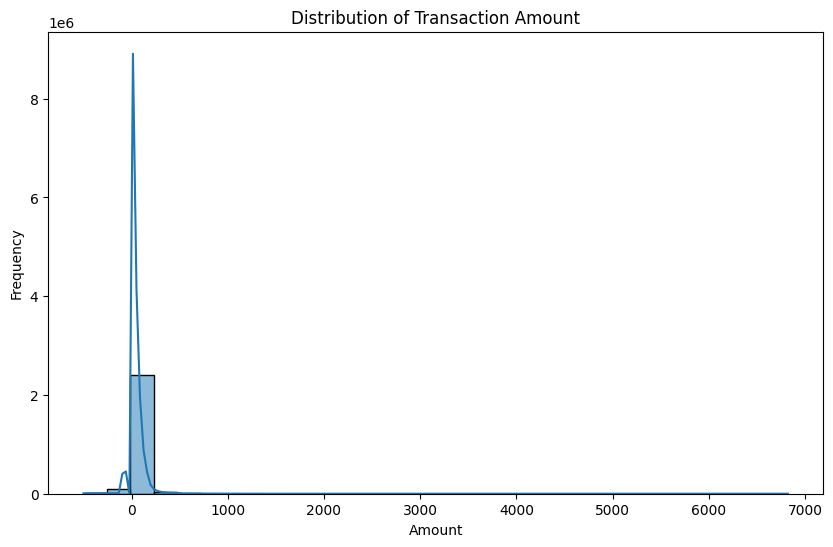

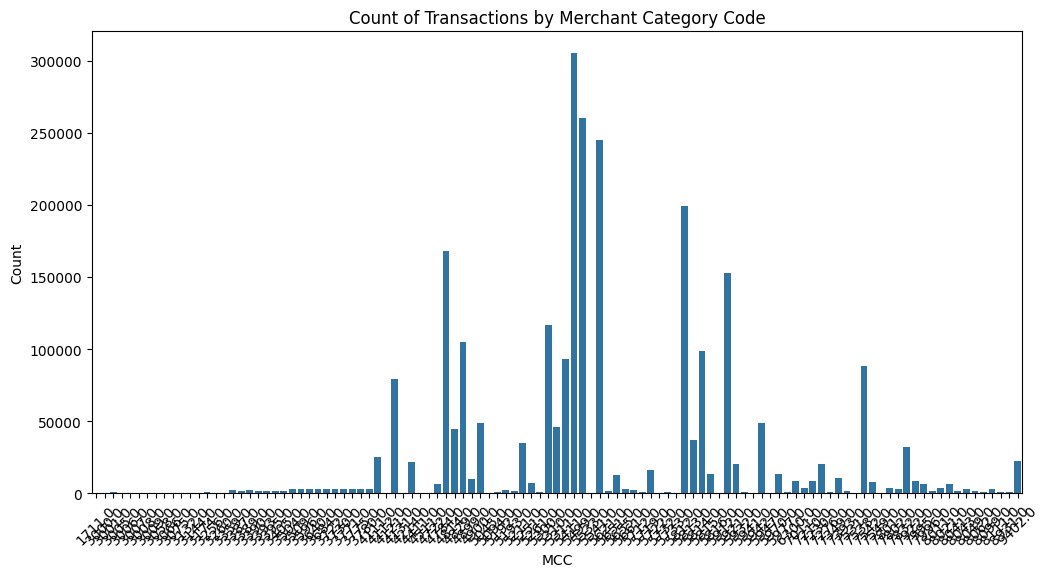

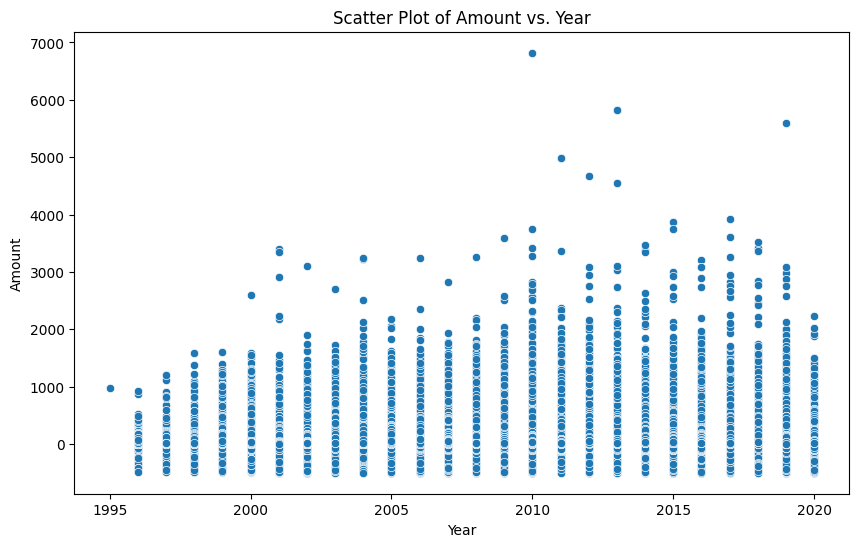

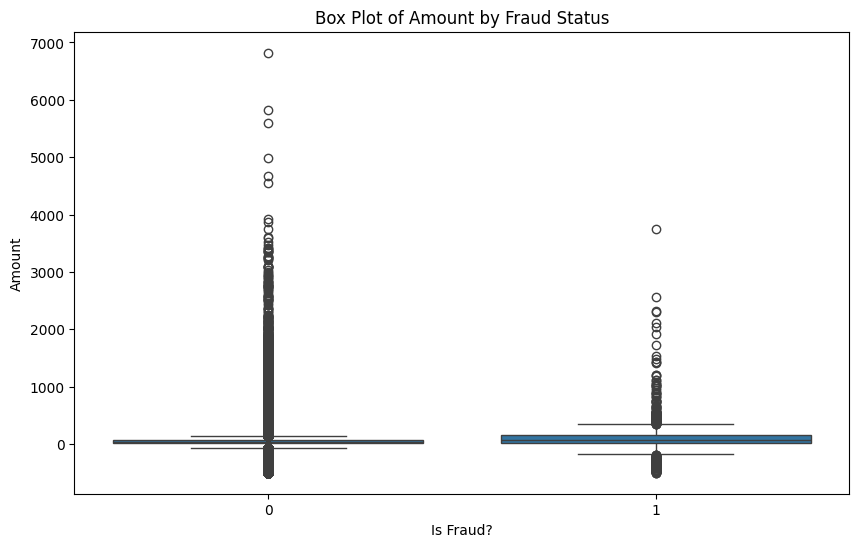

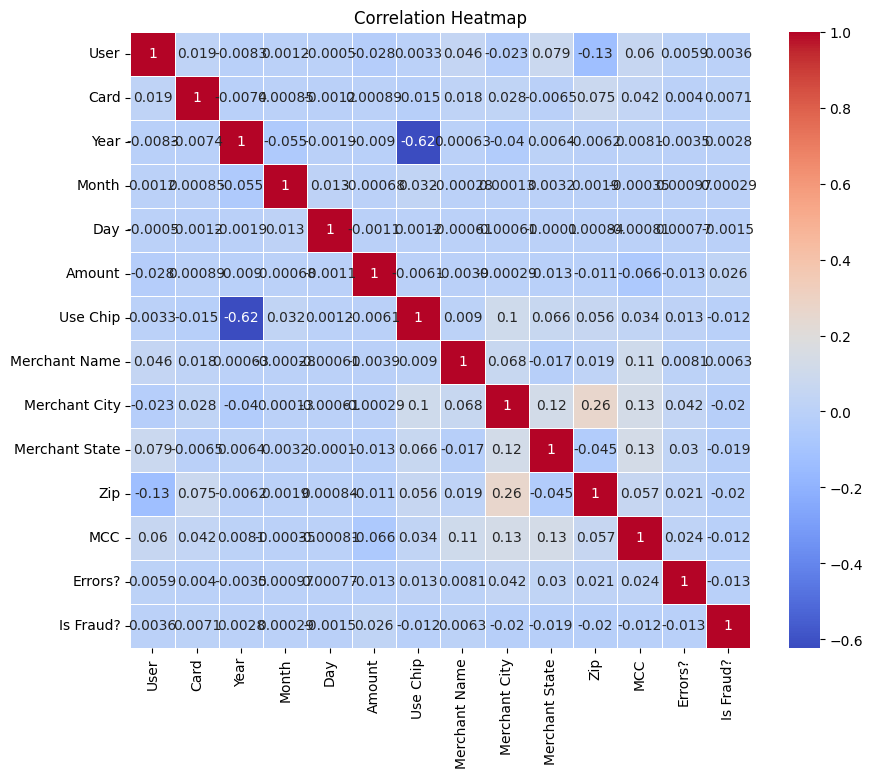

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import seaborn as sns
# Load data
data = pd.read_csv("/content/drive/MyDrive/card_transaction.v1.csv")


data['Errors?'].fillna('No Error', inplace=True)


for column in data.columns:

    if column != 'Errors?':

        most_frequent_value = data[column].mode()[0]

        data[column].fillna(most_frequent_value, inplace=True)










# Encode categorical variables
label_encoder = LabelEncoder()
categorical_cols = ["Use Chip", "Merchant City", "Merchant State", "Errors?", "Is Fraud?"]
for col in categorical_cols:
    data[col] = label_encoder.fit_transform(data[col])
data["Merchant Name"] = data["Merchant Name"].astype('category').cat.codes


data.drop("Time", axis=1, inplace=True)


data["Amount"] = data["Amount"].str.replace("$", "").astype(float)


object_cols = data.select_dtypes(include=['object']).columns
for col in object_cols:
    data[col] = data[col].astype('category').cat.codes

plt.figure(figsize=(10, 6))
sns.histplot(data['Amount'], bins=30, kde=True)
plt.title('Distribution of Transaction Amount')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()


plt.figure(figsize=(12, 6))
sns.countplot(data=data, x='MCC')
plt.title('Count of Transactions by Merchant Category Code')
plt.xlabel('MCC')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Year', y='Amount')
plt.title('Scatter Plot of Amount vs. Year')
plt.xlabel('Year')
plt.ylabel('Amount')
plt.show()


plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='Is Fraud?', y='Amount')
plt.title('Box Plot of Amount by Fraud Status')
plt.xlabel('Is Fraud?')
plt.ylabel('Amount')
plt.show()


plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()




train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# Scale data
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
val_data = scaler.transform(val_data)


input_dim = train_data.shape[1]
latent_dim = 10

inputs = Input(shape=(input_dim,))
x = Dense(128, activation='relu')(inputs)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling)([z_mean, z_log_var])

decoder_inputs = Input(shape=(latent_dim,))
x = Dense(128, activation='relu')(decoder_inputs)
outputs = Dense(input_dim, activation='sigmoid')(x)


encoder = Model(inputs, z_mean)
decoder = Model(decoder_inputs, outputs)
outputs = decoder(encoder(inputs))
vae = Model(inputs, outputs)


vae.compile(optimizer='adam', loss='mse')


history = vae.fit(train_data, train_data, epochs=10, batch_size=32, validation_data=(val_data, val_data))

# Generate synthetic data
num_samples = 2000000
synthetic_data = decoder.predict(np.random.normal(size=(num_samples, latent_dim)))


plt.figure(figsize=(15, 10))
for i, col in enumerate(data.columns):
    plt.subplot(4, 4, i+1)
    plt.hist(data[col], bins=50, alpha=0.5, color='blue', label='Real')
    plt.hist(synthetic_data[:, i], bins=50, alpha=0.5, color='orange', label='Synthetic')
    plt.title(col)
    plt.legend()
plt.tight_layout()
plt.show()
